<a href="https://colab.research.google.com/github/SH22Hwang/KoGES_OP/blob/master/OP_20230821.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 골다공증

다양한 모델로 돌려보았다~

- Traditional ML
  + Linear Model
  + KNN
  + Decison Tree
  + SVM
- GBDT
  + XGBoost
  + LGBM
- DNN
  + MLP
  + SAINT


## 유전체가 중요한가?

- 식이패턴만 있는 데이터
  - 유전체 넣기 전 PPT로 갈음

- 유전체만 있는 데이터
  - SNP
  - 지금 만들어야 함

- 둘 다 있는 데이터
  - NONSNP
  - 이전 PPT로 갈음


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as fn
from torch.utils.data import DataLoader, TensorDataset, Dataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from sklearn.metrics import mean_squared_error, roc_auc_score # roc_auc_score(y_test, y_pred)

from xgboost import XGBClassifier
import lightgbm as lgb

import numpy as np
import pandas as pd

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

In [ ]:
# Statistical Accuracy Measurement Comprehensive Gift Set
def SAMCGS(y_test, y_pred):
  # 정확도 종합 선물 세트
  accuracy = accuracy_score(y_test, y_pred)
  conf_mat = confusion_matrix(y_test, y_pred)
  # tn, fp, fn, tp = conf_mat.ravel()

  precision = precision_score(y_test, y_pred, zero_division=1) # tp / (tp + fp)
  recall = recall_score(y_test, y_pred, zero_division=1)       # tp / (tp + fn)
  f1 = f1_score(y_test, y_pred, zero_division=1) # 2 * (precision * recall) / (precision + recall)

  print(f'''
  Confusion Matrix:\n{conf_mat}\n
  Accuracy: {accuracy:.3f}
  Precison: {precision:.3f}
  Recall  : {recall:.3f}
  F1 Score: {f1:.3f}'''
  )

  # return precision, recall, f1

In [ ]:
# 데이터 불러오기
# _premeno: 폐경 전 여성
# _postmeno: 폐경 후 여성
# X_premeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/X_premeno_20230821.csv', index_col=0)
# X_postmeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/X_postmeno_20230821.csv', index_col=0)

X_premeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/X_premeno_snp_202308311746I.csv', index_col=0)
X_postmeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/X_postmeno_snp_202308311746I.csv', index_col=0)

X_premeno = pd.get_dummies(X_premeno, columns=X_premeno.columns, drop_first=True, dtype='float64') # one-hot-encoding
X_postmeno = pd.get_dummies(X_postmeno, columns=X_postmeno.columns, drop_first=True, dtype='float64')


y_premeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/y_premeno_20230821.csv', index_col=0)
y_postmeno = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/PreProcessed/y_postmeno_20230821.csv', index_col=0)

In [ ]:
# UnderSampling, OverSampling
# rus = RandomUnderSampler(random_state=42)
smt = SMOTE(random_state=42)

# X_pre, y_pre = rus.fit_resample(X_premeno, y_premeno)
# X_post, y_post = rus.fit_resample(X_postmeno, y_postmeno)
X_pre, y_pre = smt.fit_resample(X_premeno, y_premeno)
X_post, y_post = smt.fit_resample(X_postmeno, y_postmeno)

In [ ]:
X_pre_tensor = torch.tensor(X_pre.values).float()
y_pre_tensor = torch.tensor(y_pre.values).float()
X_post_tensor = torch.tensor(X_post.values).float()
y_post_tensor = torch.tensor(y_post.values).float()

In [ ]:
print(y_postmeno.value_counts())
print(y_post.value_counts())

OP
0     1846
1      721
dtype: int64
OP
0     1846
1     1846
dtype: int64


## train test split

- train set: 0.8
  - train set: 0.64
  - val set: 0.16
- test set: 0.2

[참고 자료](https://ysyblog.tistory.com/69)

In [ ]:
# train / test
X_pre_train, X_pre_test, y_pre_train, y_pre_test \
= train_test_split(X_pre, y_pre, test_size=0.2, stratify=y_pre, random_state=415) # stratify: target의 class비율에 맞춰서 분리

X_post_train, X_post_test, y_post_train, y_post_test \
= train_test_split(X_post, y_post, test_size=0.2, stratify=y_post, random_state=415)

# train / val
X_pre_train, X_pre_val, y_pre_train, y_pre_val \
= train_test_split(X_pre_train, y_pre_train, test_size=0.2, stratify=y_pre_train, random_state=415)

X_post_train, X_post_val, y_post_train, y_post_val \
= train_test_split(X_post_train, y_post_train, test_size=0.2, stratify=y_post_train, random_state=415)

# tensor / train / test
X_pre_train_tensor, X_pre_test_tensor, y_pre_train_tensor, y_pre_test_tensor \
= train_test_split(X_pre_tensor, y_pre_tensor, test_size=0.2, stratify=y_pre, random_state=415)

X_post_train_tensor, X_post_test_tensor, y_post_train_tensor, y_post_test_tensor \
= train_test_split(X_post_tensor, y_post_tensor, test_size=0.2, stratify=y_post, random_state=415)

# tensor / train / val
X_pre_train_tensor, X_pre_val_tensor, y_pre_train_tensor, y_pre_val_tensor \
= train_test_split(X_pre_train_tensor, y_pre_train_tensor, test_size=0.2, stratify=y_pre_train_tensor, random_state=415)

X_post_train_tensor, X_post_val_tensor, y_post_train_tensor, y_post_val_tensor \
= train_test_split(X_post_train_tensor, y_post_train_tensor, test_size=0.2, stratify=y_post_train_tensor, random_state=415)

## Decision Tree

In [ ]:
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
import graphviz

In [ ]:
# Defining the hyper parameters
hps = {
    'max_depth': 5,
    'min_samples_split': 4
}

# Loading the tree object
tree_pre = DecisionTreeClassifier(**hps)
tree_post = DecisionTreeClassifier(**hps)

tree_pre.fit(X_pre, y_pre)
tree_post.fit(X_post, y_post)

DecisionTreeClassifier(max_depth=5, min_samples_split=4)

In [ ]:
y_pre_pred = tree_pre.predict(X_pre)
y_post_pred = tree_post.predict(X_post)

In [ ]:
print("폐경 전 여성, Decision Tree")
SAMCGS(y_pre, y_pre_pred)
print("폐경 전 여성, Decision Tree")
SAMCGS(y_post, y_post_pred)

폐경 전 여성, Decision Tree

  Confusion Matrix:
[[1280  185]
 [ 314 1151]]

  Accuracy: 0.830
  Precison: 0.862
  Recall  : 0.786
  F1 Score: 0.822
폐경 전 여성, Decision Tree

  Confusion Matrix:
[[ 422 1424]
 [ 165 1681]]

  Accuracy: 0.570
  Precison: 0.541
  Recall  : 0.911
  F1 Score: 0.679


### 그래프

In [ ]:
# Defining the hyper parameters
hps = {
    'max_depth': 5,
    'min_samples_split': 4
}

# Loading the tree object
tree = DecisionTreeClassifier(**hps)

tree.fit(X_pre, y_pre)

DecisionTreeClassifier(max_depth=5, min_samples_split=4)

In [ ]:
export_graphviz(tree, out_file="tree.dot",
                class_names='FT',
                feature_names=X_pre.columns,
                impurity=True, filled=True)

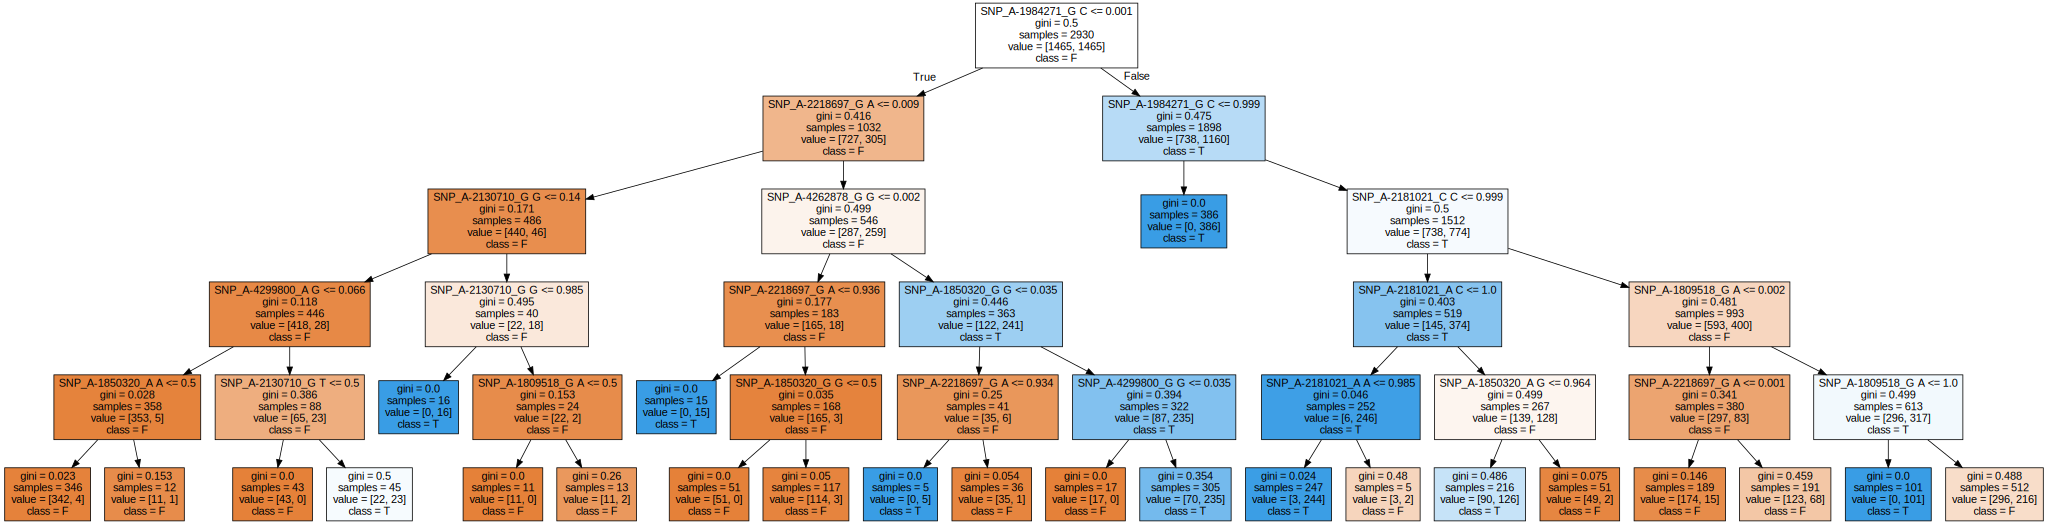

In [ ]:
with open("tree.dot") as f:
    dot_graph = f.read()

graphviz.Source(dot_graph, filename='tree.png',format='png')

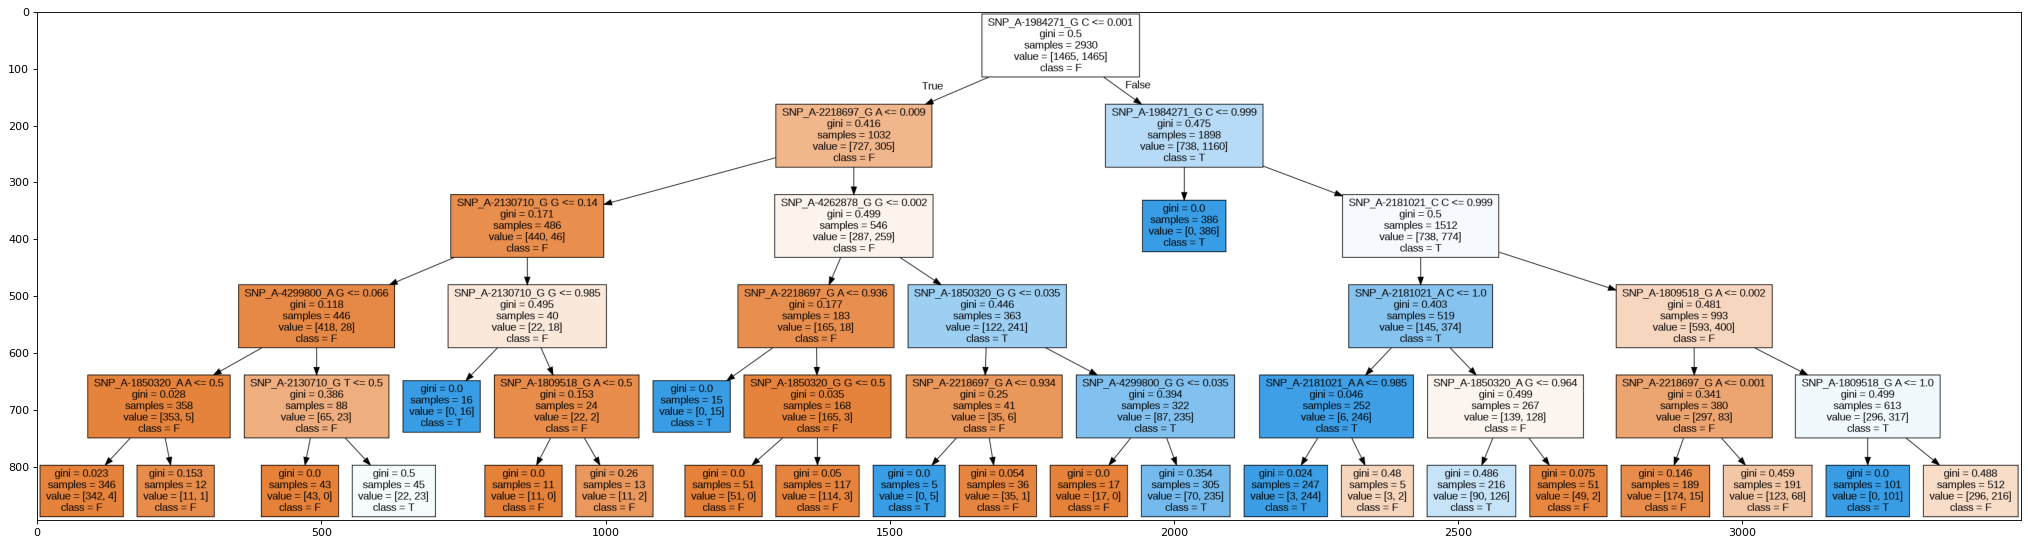

In [ ]:
!dot -Tpng tree.dot -o tree.png

tree_img = plt.imread('./tree.png')

plt.figure(num=None, figsize=(32, 9), dpi=80, facecolor='w', edgecolor='k')
plt.imshow(tree_img)

### importance

In [ ]:
# Extracting the importances by sklearn
importances_sk = tree.feature_importances_

# Creating a dataframe with the feature importance by sklearn
feature_importance_sk = {}
for i, feature in enumerate(X_pre.columns.tolist()):
    feature_importance_sk[feature] = round(importances_sk[i], 3)

print(f"Feature importance by sklearn: {feature_importance_sk}")

Feature importance by sklearn: {'SNP_A-2181021_A A': 0.004, 'SNP_A-2181021_A C': 0.077, 'SNP_A-2181021_C C': 0.083, 'SNP_A-1809518_A A': 0.0, 'SNP_A-1809518_G A': 0.118, 'SNP_A-1809518_G G': 0.0, 'SNP_A-2130710_G G': 0.033, 'SNP_A-2130710_G T': 0.014, 'SNP_A-2130710_T T': 0.0, 'SNP_A-2263153_C A': 0.0, 'SNP_A-2263153_C C': 0.0, 'SNP_A-2310995_C C': 0.0, 'SNP_A-2310995_T C': 0.0, 'SNP_A-2310995_T T': 0.0, 'SNP_A-1922415_C C': 0.0, 'SNP_A-1922415_C T': 0.0, 'SNP_A-1922415_T T': 0.0, 'SNP_A-2266073_A G': 0.0, 'SNP_A-2266073_G G': 0.0, 'SNP_A-1984271_G C': 0.336, 'SNP_A-1984271_G G': 0.0, 'SNP_A-2218697_G A': 0.149, 'SNP_A-2218697_G G': 0.0, 'SNP_A-1850320_A A': 0.0, 'SNP_A-1850320_A G': 0.029, 'SNP_A-1850320_G G': 0.03, 'SNP_A-4262878_G G': 0.094, 'SNP_A-4262878_T G': 0.0, 'SNP_A-4262878_T T': 0.0, 'SNP_A-4299800_A G': 0.01, 'SNP_A-4299800_G G': 0.023, 'SNP_A-2242511_G A': 0.0, 'SNP_A-2242511_G G': 0.0}


Text(0, 0.5, 'feature importance')

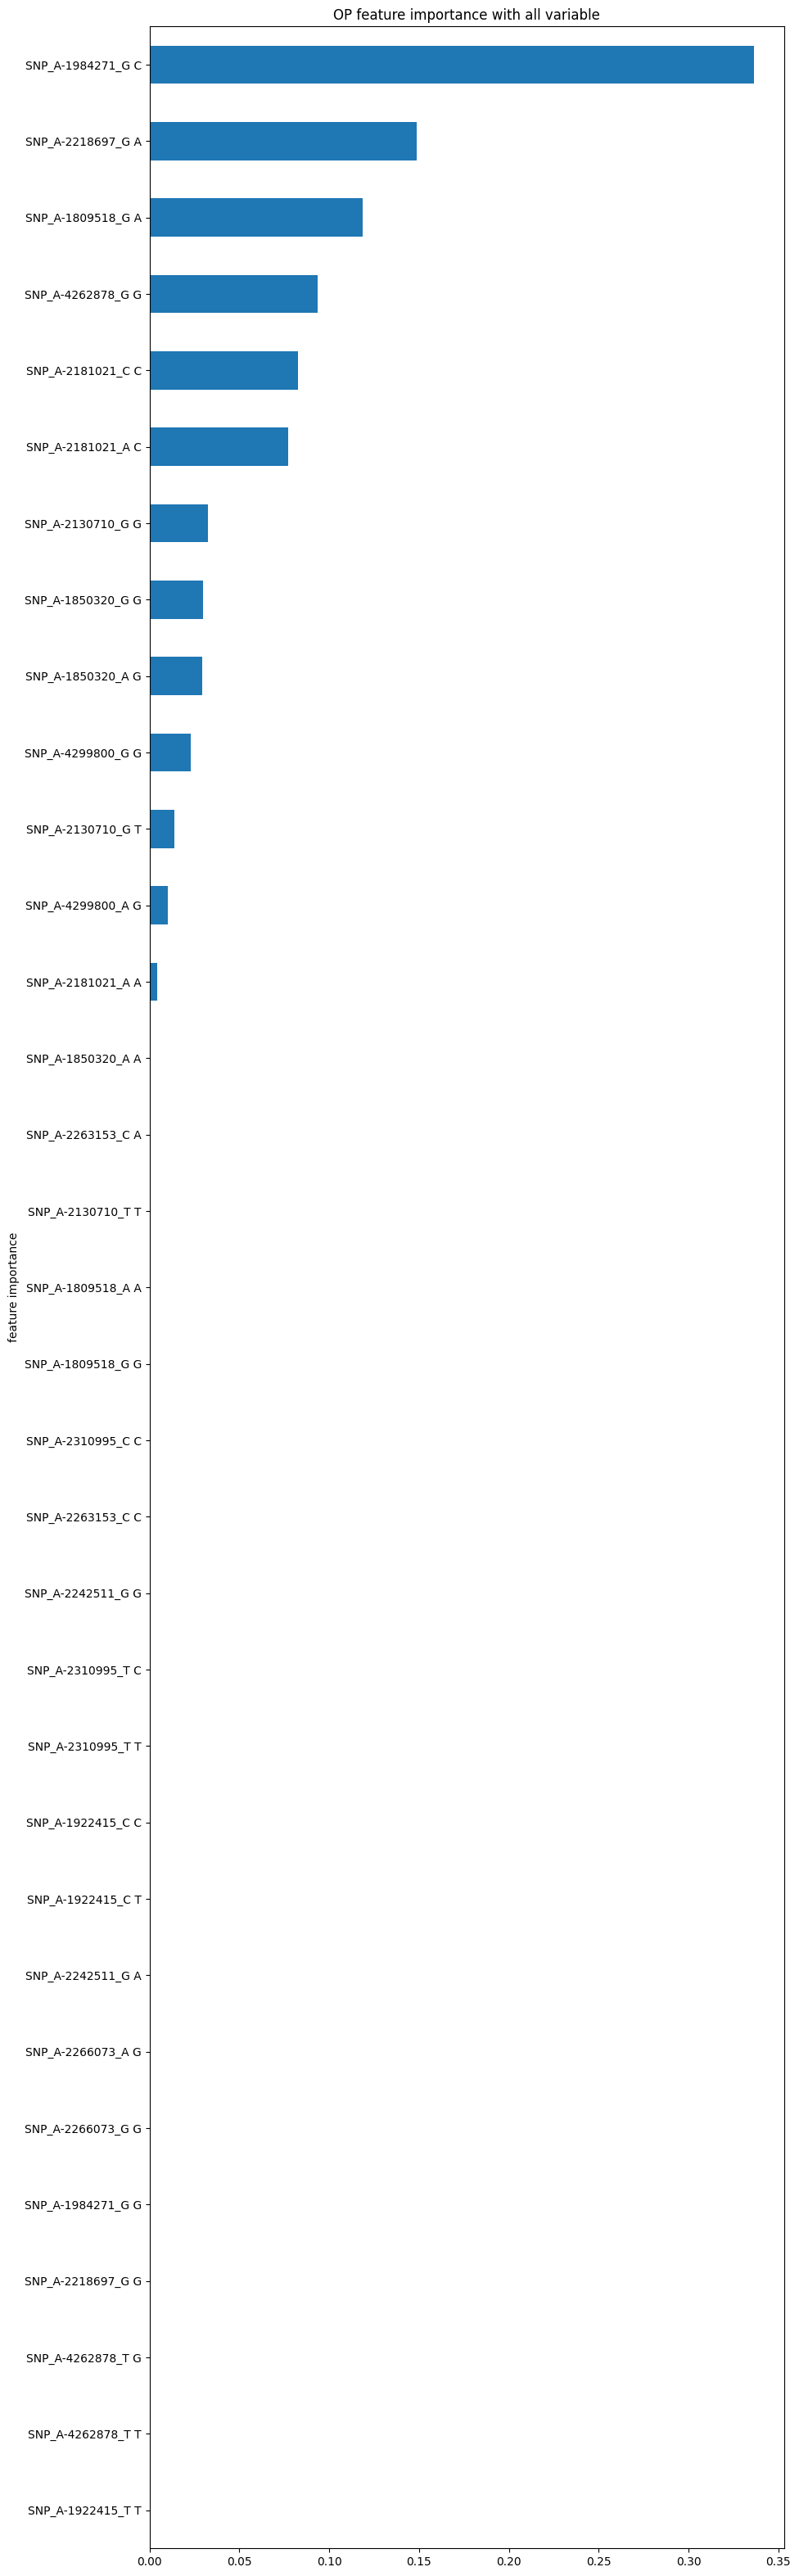

In [ ]:
importances = tree.feature_importances_

tree_importances = pd.Series(importances, index=X_pre.columns).sort_values()
fig, ax = plt.subplots(figsize=(10, 40))
tree_importances.plot.barh(ax=ax)
ax.set_title("OP feature importance with all variable")
ax.set_ylabel("feature importance")

In [ ]:
tree_importances

SNP_A-1922415_T T    0.000000
SNP_A-4262878_T T    0.000000
SNP_A-4262878_T G    0.000000
SNP_A-2218697_G G    0.000000
SNP_A-1984271_G G    0.000000
SNP_A-2266073_G G    0.000000
SNP_A-2266073_A G    0.000000
SNP_A-2242511_G A    0.000000
SNP_A-1922415_C T    0.000000
SNP_A-1922415_C C    0.000000
SNP_A-2310995_T T    0.000000
SNP_A-2310995_T C    0.000000
SNP_A-2242511_G G    0.000000
SNP_A-2263153_C C    0.000000
SNP_A-2310995_C C    0.000000
SNP_A-1809518_G G    0.000000
SNP_A-1809518_A A    0.000000
SNP_A-2130710_T T    0.000000
SNP_A-2263153_C A    0.000000
SNP_A-1850320_A A    0.000144
SNP_A-2181021_A A    0.004073
SNP_A-4299800_A G    0.010398
SNP_A-2130710_G T    0.013815
SNP_A-4299800_G G    0.022990
SNP_A-1850320_A G    0.029377
SNP_A-1850320_G G    0.029834
SNP_A-2130710_G G    0.032637
SNP_A-2181021_A C    0.076949
SNP_A-2181021_C C    0.082790
SNP_A-4262878_G G    0.093588
SNP_A-1809518_G A    0.118487
SNP_A-2218697_G A    0.148571
SNP_A-1984271_G C    0.336349
dtype: flo

## KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

knn_premeno = KNeighborsClassifier(n_neighbors=2)
knn_postmeno = KNeighborsClassifier(n_neighbors=2)

knn_premeno.fit(X_pre_train, y_pre_train)
knn_postmeno.fit(X_post_train, y_post_train)

y_premeno_pred = knn_premeno.predict(X_pre_test)
y_postmeno_pred = knn_postmeno.predict(X_post_test)

/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)
/usr/local/lib/python3.10/dist-packages/sklearn/neighbors/_classification.py:215: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return self._fit(X, y)


In [ ]:
print("폐경 전 여성, KNN")
SAMCGS(y_pre_test, y_premeno_pred)
print("폐경 후 여성, KNN")
SAMCGS(y_post_test, y_postmeno_pred)

폐경 전 여성, KNN

  Confusion Matrix:
[[262  31]
 [ 15 278]]

  Accuracy: 0.922
  Precison: 0.900
  Recall  : 0.949
  F1 Score: 0.924
폐경 후 여성, KNN

  Confusion Matrix:
[[315  54]
 [199 171]]

  Accuracy: 0.658
  Precison: 0.760
  Recall  : 0.462
  F1 Score: 0.575


## SVM

In [ ]:
# Define the linear SVM model
class SVM(nn.Module):
    def __init__(self, input_dim):
        super(SVM, self).__init__()
        self.fc1 = nn.Linear(input_dim, 1)

    def forward(self, x):
        x = self.fc1(x)
        return x

In [ ]:
svm_model_pre = SVM(X_pre_train.shape[1])
svm_model_post = SVM(X_post_train.shape[1])

# Define the loss function and optimizer
criterion_pre = nn.HingeEmbeddingLoss()
criterion_post = nn.HingeEmbeddingLoss()

optimizer_pre = optim.SGD(svm_model_pre.parameters(), lr=0.01)
optimizer_post = optim.SGD(svm_model_post.parameters(), lr=0.01)

In [ ]:
# Train the model
for epoch in range(100):
    optimizer_pre.zero_grad()
    optimizer_post.zero_grad()

    output_pre = svm_model_pre(X_pre_train_tensor).squeeze()
    output_post = svm_model_post(X_post_train_tensor).squeeze()

    loss_pre = criterion_pre(output_pre, 2 * y_pre_train_tensor.float()-1)
    loss_post = criterion_pre(output_post, 2 * y_post_train_tensor.float()-1)

    loss_pre.backward()
    loss_post.backward()

    optimizer_pre.step()
    optimizer_post.step()

# Make predictions on the test set
y_pre_pred = torch.sign(svm_model_pre(X_pre_test_tensor).squeeze()).detach().numpy()
y_post_pred = torch.sign(svm_model_post(X_post_test_tensor).squeeze()).detach().numpy()

In [ ]:
y_premeno_pred = np.where(y_pre_pred < 0, 0, 1)
unique, counts = np.unique(y_pre_pred, return_counts=True)
print(dict(zip(unique, counts)))

{-1.0: 265, 1.0: 321}


In [ ]:
y_post_test.value_counts()

OP
1     370
0     369
dtype: int64

In [ ]:
y_postmeno_pred = np.where(y_post_pred < 0, 0, 1)
unique, counts = np.unique(y_premeno_pred, return_counts=True)
print(dict(zip(unique, counts)))

{0: 265, 1: 321}


In [ ]:
print("폐경 전 여성, SVM")
SAMCGS(y_pre_test.to_numpy(), y_premeno_pred)
print("폐경 후 여성, SVM")
SAMCGS(y_post_test, y_postmeno_pred)

폐경 전 여성, SVM

  Confusion Matrix:
[[140 153]
 [125 168]]

  Accuracy: 0.526
  Precison: 0.523
  Recall  : 0.573
  F1 Score: 0.547
폐경 후 여성, SVM

  Confusion Matrix:
[[274  95]
 [300  70]]

  Accuracy: 0.465
  Precison: 0.424
  Recall  : 0.189
  F1 Score: 0.262


## XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV

# create model instance
xgb_pre = XGBClassifier(n_estimators=300, # 나무의 개수
                        # early_stopping_rounds = 100,
                        max_depth=5,
                        learning_rate=0.01,
                        objective='binary:logistic',
                        silent=1)

xgb_post = XGBClassifier(n_estimators=300, # 나무의 개수
                        #  early_stopping_rounds = 100,
                         max_depth=5,
                         learning_rate=0.01,
                         objective='binary:logistic',
                         silent=1)

# 후보 파라미터 선정
params = {'max_depth':[5,7], 'min_child_weight':[1,3], 'colsample_bytree':[0.5,0.75]}

# gridsearchcv 객체 정보 입력(어떤 모델, 파라미터 후보, 교차검증 몇 번)
gridcv_pre = GridSearchCV(xgb_pre, param_grid=params, cv=3)
gridcv_post = GridSearchCV(xgb_post, param_grid=params, cv=3)

gridcv_pre.fit(X_pre_train, y_pre_train,
               early_stopping_rounds=30,
               eval_metric='auc',
               eval_set=[(X_pre_val, y_pre_val)])

gridcv_post.fit(X_post_train, y_post_train,
                early_stopping_rounds=30,
                eval_metric='auc',
                eval_set=[(X_post_val, y_post_val)])

[08:45:45] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-auc:0.87151
[1]	validation_0-auc:0.89130
[2]	validation_0-auc:0.89493
[3]	validation_0-auc:0.89936
[4]	validation_0-auc:0.93750
[5]	validation_0-auc:0.93699
[6]	validation_0-auc:0.95872
[7]	validation_0-auc:0.96847
[8]	validation_0-auc:0.97493
[9]	validation_0-auc:0.98051
[10]	validation_0-auc:0.97858
[11]	validation_0-auc:0.97905
[12]	validation_0-auc:0.98103
[13]	validation_0-auc:0.98129
[14]	validation_0-auc:0.98185
[15]	validation_0-auc:0.98071
[16]	validation_0-auc:0.98221
[17]	validation_0-auc:0.98209
[18]	validation_0-auc:0.98305
[19]	validation_0-auc:0.98469
[20]	validation_0-auc:0.98451
[21]	validation_0-auc:0.98403
[22]	validation_0-auc:0.98378
[23]	validation_0-auc:0.98358
[24]	validation_0-auc:0.98342
[25]	validation_0-auc:0.98461
[26]	validation_0-auc:0.98450
[27]	validation_0-auc:0.98490
[28]	validation_0-auc:0.98446
[29]	validation_0-auc:0.98444
[30]	validation_0-auc:0.98

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.98514
[33]	validation_0-auc:0.98547
[34]	validation_0-auc:0.98542
[35]	validation_0-auc:0.98607
[36]	validation_0-auc:0.98634
[37]	validation_0-auc:0.98672
[38]	validation_0-auc:0.98694
[39]	validation_0-auc:0.98769
[40]	validation_0-auc:0.98789
[41]	validation_0-auc:0.98765
[42]	validation_0-auc:0.98796
[43]	validation_0-auc:0.98756
[44]	validation_0-auc:0.98738
[45]	validation_0-auc:0.98771
[46]	validation_0-auc:0.98822
[47]	validation_0-auc:0.98803
[48]	validation_0-auc:0.98780
[49]	validation_0-auc:0.98796
[50]	validation_0-auc:0.98758
[51]	validation_0-auc:0.98825
[52]	validation_0-auc:0.98800
[53]	validation_0-auc:0.98831
[54]	validation_0-auc:0.98840
[55]	validation_0-auc:0.98862
[56]	validation_0-auc:0.98896
[57]	validation_0-auc:0.98896
[58]	validation_0-auc:0.98905
[59]	validation_0-auc:0.98903
[60]	validation_0-auc:0.98920
[61]	validation_0-auc:0.98922
[62]	validation_0-auc:0.98938
[63]	validation_0-auc:0.98948
[64]	validation_0-auc:0.98933
[65]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-auc:0.98738
[31]	validation_0-auc:0.98747
[32]	validation_0-auc:0.98776
[33]	validation_0-auc:0.98820
[34]	validation_0-auc:0.98849
[35]	validation_0-auc:0.98833
[36]	validation_0-auc:0.98843
[37]	validation_0-auc:0.98874
[38]	validation_0-auc:0.98874
[39]	validation_0-auc:0.98847
[40]	validation_0-auc:0.98834
[41]	validation_0-auc:0.98823
[42]	validation_0-auc:0.98793
[43]	validation_0-auc:0.98776
[44]	validation_0-auc:0.98791
[45]	validation_0-auc:0.98807
[46]	validation_0-auc:0.98858
[47]	validation_0-auc:0.98871
[48]	validation_0-auc:0.98853
[49]	validation_0-auc:0.98918
[50]	validation_0-auc:0.98903
[51]	validation_0-auc:0.98927
[52]	validation_0-auc:0.98942
[53]	validation_0-auc:0.98927
[54]	validation_0-auc:0.98922
[55]	validation_0-auc:0.98931
[56]	validation_0-auc:0.99007
[57]	validation_0-auc:0.98993
[58]	validation_0-auc:0.98982
[59]	validation_0-auc:0.98976
[60]	validation_0-auc:0.98974
[61]	validation_0-auc:0.98982
[62]	validation_0-auc:0.99003
[63]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[32]	validation_0-auc:0.98954
[33]	validation_0-auc:0.98982
[34]	validation_0-auc:0.99007
[35]	validation_0-auc:0.98987
[36]	validation_0-auc:0.99002
[37]	validation_0-auc:0.99018
[38]	validation_0-auc:0.99027
[39]	validation_0-auc:0.99034
[40]	validation_0-auc:0.99027
[41]	validation_0-auc:0.99016
[42]	validation_0-auc:0.99013
[43]	validation_0-auc:0.98985
[44]	validation_0-auc:0.98991
[45]	validation_0-auc:0.98998
[46]	validation_0-auc:0.99043
[47]	validation_0-auc:0.99005
[48]	validation_0-auc:0.98962
[49]	validation_0-auc:0.99022
[50]	validation_0-auc:0.99018
[51]	validation_0-auc:0.99058
[52]	validation_0-auc:0.99031
[53]	validation_0-auc:0.99043
[54]	validation_0-auc:0.99045
[55]	validation_0-auc:0.99063
[56]	validation_0-auc:0.99103
[57]	validation_0-auc:0.99127
[58]	validation_0-auc:0.99111
[59]	validation_0-auc:0.99107
[60]	validation_0-auc:0.99109
[61]	validation_0-auc:0.99114
[62]	validation_0-auc:0.99113
[63]	validation_0-auc:0.99105
[64]	validation_0-auc:0.99109
[65]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.98343
[32]	validation_0-auc:0.98383
[33]	validation_0-auc:0.98451
[34]	validation_0-auc:0.98445
[35]	validation_0-auc:0.98522
[36]	validation_0-auc:0.98545
[37]	validation_0-auc:0.98582
[38]	validation_0-auc:0.98634
[39]	validation_0-auc:0.98683
[40]	validation_0-auc:0.98725
[41]	validation_0-auc:0.98691
[42]	validation_0-auc:0.98722
[43]	validation_0-auc:0.98702
[44]	validation_0-auc:0.98694
[45]	validation_0-auc:0.98714
[46]	validation_0-auc:0.98747
[47]	validation_0-auc:0.98731
[48]	validation_0-auc:0.98700
[49]	validation_0-auc:0.98731
[50]	validation_0-auc:0.98725
[51]	validation_0-auc:0.98758
[52]	validation_0-auc:0.98727
[53]	validation_0-auc:0.98789
[54]	validation_0-auc:0.98814
[55]	validation_0-auc:0.98818
[56]	validation_0-auc:0.98862
[57]	validation_0-auc:0.98849
[58]	validation_0-auc:0.98843
[59]	validation_0-auc:0.98818
[60]	validation_0-auc:0.98842
[61]	validation_0-auc:0.98845
[62]	validation_0-auc:0.98867
[63]	validation_0-auc:0.98868
[64]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[34]	validation_0-auc:0.98783
[35]	validation_0-auc:0.98754
[36]	validation_0-auc:0.98818
[37]	validation_0-auc:0.98823
[38]	validation_0-auc:0.98814
[39]	validation_0-auc:0.98805
[40]	validation_0-auc:0.98802
[41]	validation_0-auc:0.98774
[42]	validation_0-auc:0.98758
[43]	validation_0-auc:0.98740
[44]	validation_0-auc:0.98758
[45]	validation_0-auc:0.98756
[46]	validation_0-auc:0.98820
[47]	validation_0-auc:0.98840
[48]	validation_0-auc:0.98849
[49]	validation_0-auc:0.98858
[50]	validation_0-auc:0.98854
[51]	validation_0-auc:0.98880
[52]	validation_0-auc:0.98878
[53]	validation_0-auc:0.98882
[54]	validation_0-auc:0.98871
[55]	validation_0-auc:0.98883
[56]	validation_0-auc:0.98951
[57]	validation_0-auc:0.98942
[58]	validation_0-auc:0.98929
[59]	validation_0-auc:0.98911
[60]	validation_0-auc:0.98922
[61]	validation_0-auc:0.98909
[62]	validation_0-auc:0.98914
[63]	validation_0-auc:0.98913
[64]	validation_0-auc:0.98923
[65]	validation_0-auc:0.98951
[66]	validation_0-auc:0.98940
[67]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.98883
[30]	validation_0-auc:0.98848
[31]	validation_0-auc:0.98841
[32]	validation_0-auc:0.98900
[33]	validation_0-auc:0.98874
[34]	validation_0-auc:0.98925
[35]	validation_0-auc:0.98922
[36]	validation_0-auc:0.98898
[37]	validation_0-auc:0.98903
[38]	validation_0-auc:0.98923
[39]	validation_0-auc:0.98942
[40]	validation_0-auc:0.98943
[41]	validation_0-auc:0.98938
[42]	validation_0-auc:0.98931
[43]	validation_0-auc:0.98920
[44]	validation_0-auc:0.98914
[45]	validation_0-auc:0.98911
[46]	validation_0-auc:0.98947
[47]	validation_0-auc:0.98920
[48]	validation_0-auc:0.98922
[49]	validation_0-auc:0.98949
[50]	validation_0-auc:0.98947
[51]	validation_0-auc:0.98985
[52]	validation_0-auc:0.98978
[53]	validation_0-auc:0.98976
[54]	validation_0-auc:0.98993
[55]	validation_0-auc:0.99005
[56]	validation_0-auc:0.99038
[57]	validation_0-auc:0.99042
[58]	validation_0-auc:0.99025
[59]	validation_0-auc:0.99034
[60]	validation_0-auc:0.99045
[61]	validation_0-auc:0.99040
[62]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-auc:0.99075
[26]	validation_0-auc:0.99095
[27]	validation_0-auc:0.99121
[28]	validation_0-auc:0.99088
[29]	validation_0-auc:0.99077
[30]	validation_0-auc:0.99092
[31]	validation_0-auc:0.99104
[32]	validation_0-auc:0.99128
[33]	validation_0-auc:0.99144
[34]	validation_0-auc:0.99148
[35]	validation_0-auc:0.99123
[36]	validation_0-auc:0.99170
[37]	validation_0-auc:0.99188
[38]	validation_0-auc:0.99168
[39]	validation_0-auc:0.99179
[40]	validation_0-auc:0.99183
[41]	validation_0-auc:0.99170
[42]	validation_0-auc:0.99192
[43]	validation_0-auc:0.99188
[44]	validation_0-auc:0.99192
[45]	validation_0-auc:0.99179
[46]	validation_0-auc:0.99215
[47]	validation_0-auc:0.99201
[48]	validation_0-auc:0.99201
[49]	validation_0-auc:0.99201
[50]	validation_0-auc:0.99195
[51]	validation_0-auc:0.99224
[52]	validation_0-auc:0.99208
[53]	validation_0-auc:0.99226
[54]	validation_0-auc:0.99246
[55]	validation_0-auc:0.99241
[56]	validation_0-auc:0.99257
[57]	validation_0-auc:0.99241
[58]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.99070
[28]	validation_0-auc:0.99064
[29]	validation_0-auc:0.99063
[30]	validation_0-auc:0.99081
[31]	validation_0-auc:0.99066
[32]	validation_0-auc:0.99128
[33]	validation_0-auc:0.99150
[34]	validation_0-auc:0.99170
[35]	validation_0-auc:0.99144
[36]	validation_0-auc:0.99186
[37]	validation_0-auc:0.99197
[38]	validation_0-auc:0.99201
[39]	validation_0-auc:0.99181
[40]	validation_0-auc:0.99159
[41]	validation_0-auc:0.99148
[42]	validation_0-auc:0.99153
[43]	validation_0-auc:0.99168
[44]	validation_0-auc:0.99170
[45]	validation_0-auc:0.99188
[46]	validation_0-auc:0.99228
[47]	validation_0-auc:0.99213
[48]	validation_0-auc:0.99204
[49]	validation_0-auc:0.99246
[50]	validation_0-auc:0.99246
[51]	validation_0-auc:0.99277
[52]	validation_0-auc:0.99254
[53]	validation_0-auc:0.99266
[54]	validation_0-auc:0.99254
[55]	validation_0-auc:0.99255
[56]	validation_0-auc:0.99268
[57]	validation_0-auc:0.99279
[58]	validation_0-auc:0.99275
[59]	validation_0-auc:0.99277
[60]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.99364
[30]	validation_0-auc:0.99350
[31]	validation_0-auc:0.99357
[32]	validation_0-auc:0.99355
[33]	validation_0-auc:0.99354
[34]	validation_0-auc:0.99346
[35]	validation_0-auc:0.99332
[36]	validation_0-auc:0.99321
[37]	validation_0-auc:0.99346
[38]	validation_0-auc:0.99359
[39]	validation_0-auc:0.99352
[40]	validation_0-auc:0.99343
[41]	validation_0-auc:0.99341
[42]	validation_0-auc:0.99350
[43]	validation_0-auc:0.99334
[08:45:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-auc:0.91834
[1]	validation_0-auc:0.96130
[2]	validation_0-auc:0.95839
[3]	validation_0-auc:0.96195
[4]	validation_0-auc:0.98198
[5]	validation_0-auc:0.98122
[6]	validation_0-auc:0.98528
[7]	validation_0-auc:0.98838
[8]	validation_0-auc:0.98813
[9]	validation_0-auc:0.99154
[10]	validation_0-auc:0.99063
[11]	validation_0-auc:0.98974
[12]	validation_0-auc:0.99002
[13]	validation_0-auc:0.99182
[14]	validation_0-auc:0.99202
[15]	validation_0-auc:0.99

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.99087
[29]	validation_0-auc:0.99067
[30]	validation_0-auc:0.99076
[31]	validation_0-auc:0.99094
[32]	validation_0-auc:0.99120
[33]	validation_0-auc:0.99136
[34]	validation_0-auc:0.99138
[35]	validation_0-auc:0.99113
[36]	validation_0-auc:0.99136
[37]	validation_0-auc:0.99158
[38]	validation_0-auc:0.99156
[39]	validation_0-auc:0.99185
[40]	validation_0-auc:0.99167
[41]	validation_0-auc:0.99149
[42]	validation_0-auc:0.99158
[43]	validation_0-auc:0.99160
[44]	validation_0-auc:0.99169
[08:45:53] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-auc:0.91979
[1]	validation_0-auc:0.95041
[2]	validation_0-auc:0.94453
[3]	validation_0-auc:0.95673
[4]	validation_0-auc:0.97361
[5]	validation_0-auc:0.97066
[6]	validation_0-auc:0.97491
[7]	validation_0-auc:0.97729
[8]	validation_0-auc:0.98306
[9]	validation_0-auc:0.98653
[10]	validation_0-auc:0.98664
[11]	validation_0-auc:0.98864
[12]	validation_0-auc:0.98966
[13]	validation_0-auc:0.98

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.98951
[29]	validation_0-auc:0.98971
[30]	validation_0-auc:0.99000
[31]	validation_0-auc:0.98973
[32]	validation_0-auc:0.99020
[33]	validation_0-auc:0.99033
[34]	validation_0-auc:0.99069
[35]	validation_0-auc:0.99049
[36]	validation_0-auc:0.99093
[37]	validation_0-auc:0.99105
[38]	validation_0-auc:0.99103
[39]	validation_0-auc:0.99085
[40]	validation_0-auc:0.99071
[41]	validation_0-auc:0.99043
[42]	validation_0-auc:0.99071
[43]	validation_0-auc:0.99069
[44]	validation_0-auc:0.99067
[45]	validation_0-auc:0.99047
[46]	validation_0-auc:0.99111
[47]	validation_0-auc:0.99089
[48]	validation_0-auc:0.99083
[49]	validation_0-auc:0.99129
[50]	validation_0-auc:0.99133
[51]	validation_0-auc:0.99178
[52]	validation_0-auc:0.99171
[53]	validation_0-auc:0.99174
[54]	validation_0-auc:0.99163
[55]	validation_0-auc:0.99156
[56]	validation_0-auc:0.99211
[57]	validation_0-auc:0.99218
[58]	validation_0-auc:0.99203
[59]	validation_0-auc:0.99189
[60]	validation_0-auc:0.99197
[61]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-auc:0.99302
[25]	validation_0-auc:0.99309
[26]	validation_0-auc:0.99284
[27]	validation_0-auc:0.99273
[28]	validation_0-auc:0.99265
[29]	validation_0-auc:0.99254
[30]	validation_0-auc:0.99274
[31]	validation_0-auc:0.99258
[32]	validation_0-auc:0.99264
[33]	validation_0-auc:0.99264
[34]	validation_0-auc:0.99276
[35]	validation_0-auc:0.99267
[36]	validation_0-auc:0.99262
[37]	validation_0-auc:0.99280
[38]	validation_0-auc:0.99291
[39]	validation_0-auc:0.99284
[40]	validation_0-auc:0.99285
[41]	validation_0-auc:0.99278
[08:45:54] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-auc:0.87344
[1]	validation_0-auc:0.91937
[2]	validation_0-auc:0.92012
[3]	validation_0-auc:0.92124
[4]	validation_0-auc:0.93273
[5]	validation_0-auc:0.93001
[6]	validation_0-auc:0.95379
[7]	validation_0-auc:0.95539
[8]	validation_0-auc:0.95316
[9]	validation_0-auc:0.94871
[10]	validation_0-auc:0.95210
[11]	validation_0-auc:0.94972
[12]	validation_0-auc:0.95

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.95873
[28]	validation_0-auc:0.95959
[29]	validation_0-auc:0.95939
[30]	validation_0-auc:0.96156
[31]	validation_0-auc:0.96092
[32]	validation_0-auc:0.96243
[33]	validation_0-auc:0.96523
[34]	validation_0-auc:0.96674
[35]	validation_0-auc:0.96579
[36]	validation_0-auc:0.96576
[37]	validation_0-auc:0.96481
[38]	validation_0-auc:0.96676
[39]	validation_0-auc:0.96827
[40]	validation_0-auc:0.96785
[41]	validation_0-auc:0.96901
[42]	validation_0-auc:0.97079
[43]	validation_0-auc:0.97049
[44]	validation_0-auc:0.97049
[45]	validation_0-auc:0.97017
[46]	validation_0-auc:0.97064
[47]	validation_0-auc:0.96995
[48]	validation_0-auc:0.96980
[49]	validation_0-auc:0.96993
[50]	validation_0-auc:0.97053
[51]	validation_0-auc:0.97144
[52]	validation_0-auc:0.97062
[53]	validation_0-auc:0.97210
[54]	validation_0-auc:0.97236
[55]	validation_0-auc:0.97325
[56]	validation_0-auc:0.97370
[57]	validation_0-auc:0.97450
[58]	validation_0-auc:0.97510
[59]	validation_0-auc:0.97590
[60]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-auc:0.97796
[31]	validation_0-auc:0.97718
[32]	validation_0-auc:0.97710
[33]	validation_0-auc:0.97756
[34]	validation_0-auc:0.97871
[35]	validation_0-auc:0.97929
[36]	validation_0-auc:0.97909
[37]	validation_0-auc:0.97865
[38]	validation_0-auc:0.97917
[39]	validation_0-auc:0.97959
[40]	validation_0-auc:0.97942
[41]	validation_0-auc:0.97955
[42]	validation_0-auc:0.98002
[43]	validation_0-auc:0.98055
[44]	validation_0-auc:0.98066
[45]	validation_0-auc:0.98046
[46]	validation_0-auc:0.98053
[47]	validation_0-auc:0.98044
[48]	validation_0-auc:0.98022
[49]	validation_0-auc:0.98031
[50]	validation_0-auc:0.98079
[51]	validation_0-auc:0.98144
[52]	validation_0-auc:0.98124
[53]	validation_0-auc:0.98155
[54]	validation_0-auc:0.98171
[55]	validation_0-auc:0.98208
[56]	validation_0-auc:0.98210
[57]	validation_0-auc:0.98210
[58]	validation_0-auc:0.98181
[59]	validation_0-auc:0.98250
[60]	validation_0-auc:0.98206
[61]	validation_0-auc:0.98281
[62]	validation_0-auc:0.98266
[63]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.96853
[32]	validation_0-auc:0.97049
[33]	validation_0-auc:0.97401
[34]	validation_0-auc:0.97572
[35]	validation_0-auc:0.97558
[36]	validation_0-auc:0.97521
[37]	validation_0-auc:0.97536
[38]	validation_0-auc:0.97658
[39]	validation_0-auc:0.97729
[40]	validation_0-auc:0.97765
[41]	validation_0-auc:0.97732
[42]	validation_0-auc:0.97818
[43]	validation_0-auc:0.97867
[44]	validation_0-auc:0.97921
[45]	validation_0-auc:0.97967
[46]	validation_0-auc:0.98012
[47]	validation_0-auc:0.98032
[48]	validation_0-auc:0.98029
[49]	validation_0-auc:0.98043
[50]	validation_0-auc:0.98036
[51]	validation_0-auc:0.98094
[52]	validation_0-auc:0.98121
[53]	validation_0-auc:0.98229
[54]	validation_0-auc:0.98228
[55]	validation_0-auc:0.98201
[56]	validation_0-auc:0.98244
[57]	validation_0-auc:0.98268
[58]	validation_0-auc:0.98277
[59]	validation_0-auc:0.98319
[60]	validation_0-auc:0.98337
[61]	validation_0-auc:0.98390
[62]	validation_0-auc:0.98379
[63]	validation_0-auc:0.98432
[64]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.95856
[32]	validation_0-auc:0.96012
[33]	validation_0-auc:0.96327
[34]	validation_0-auc:0.96485
[35]	validation_0-auc:0.96350
[36]	validation_0-auc:0.96368
[37]	validation_0-auc:0.96310
[38]	validation_0-auc:0.96501
[39]	validation_0-auc:0.96656
[40]	validation_0-auc:0.96610
[41]	validation_0-auc:0.96688
[42]	validation_0-auc:0.96905
[43]	validation_0-auc:0.96887
[44]	validation_0-auc:0.96950
[45]	validation_0-auc:0.96929
[46]	validation_0-auc:0.96963
[47]	validation_0-auc:0.96901
[48]	validation_0-auc:0.96839
[49]	validation_0-auc:0.96799
[50]	validation_0-auc:0.96854
[51]	validation_0-auc:0.96932
[52]	validation_0-auc:0.96925
[53]	validation_0-auc:0.97079
[54]	validation_0-auc:0.97199
[55]	validation_0-auc:0.97160
[56]	validation_0-auc:0.97199
[57]	validation_0-auc:0.97277
[58]	validation_0-auc:0.97302
[59]	validation_0-auc:0.97399
[60]	validation_0-auc:0.97437
[61]	validation_0-auc:0.97490
[62]	validation_0-auc:0.97540
[63]	validation_0-auc:0.97542
[64]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.97721
[32]	validation_0-auc:0.97781
[33]	validation_0-auc:0.97887
[34]	validation_0-auc:0.98036
[35]	validation_0-auc:0.98032
[36]	validation_0-auc:0.97951
[37]	validation_0-auc:0.97932
[38]	validation_0-auc:0.97976
[39]	validation_0-auc:0.98029
[40]	validation_0-auc:0.97974
[41]	validation_0-auc:0.97900
[42]	validation_0-auc:0.97927
[43]	validation_0-auc:0.98040
[44]	validation_0-auc:0.98032
[45]	validation_0-auc:0.98021
[46]	validation_0-auc:0.97996
[47]	validation_0-auc:0.97936
[48]	validation_0-auc:0.97941
[49]	validation_0-auc:0.97992
[50]	validation_0-auc:0.98058
[51]	validation_0-auc:0.98109
[52]	validation_0-auc:0.98203
[53]	validation_0-auc:0.98234
[54]	validation_0-auc:0.98185
[55]	validation_0-auc:0.98185
[56]	validation_0-auc:0.98151
[57]	validation_0-auc:0.98216
[58]	validation_0-auc:0.98183
[59]	validation_0-auc:0.98212
[60]	validation_0-auc:0.98207
[61]	validation_0-auc:0.98238
[62]	validation_0-auc:0.98231
[63]	validation_0-auc:0.98234
[64]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.96588
[30]	validation_0-auc:0.96738
[31]	validation_0-auc:0.96610
[32]	validation_0-auc:0.96870
[33]	validation_0-auc:0.97219
[34]	validation_0-auc:0.97423
[35]	validation_0-auc:0.97432
[36]	validation_0-auc:0.97425
[37]	validation_0-auc:0.97420
[38]	validation_0-auc:0.97605
[39]	validation_0-auc:0.97694
[40]	validation_0-auc:0.97687
[41]	validation_0-auc:0.97634
[42]	validation_0-auc:0.97769
[43]	validation_0-auc:0.97758
[44]	validation_0-auc:0.97843
[45]	validation_0-auc:0.97876
[46]	validation_0-auc:0.97936
[47]	validation_0-auc:0.97949
[48]	validation_0-auc:0.97960
[49]	validation_0-auc:0.97965
[50]	validation_0-auc:0.98005
[51]	validation_0-auc:0.98091
[52]	validation_0-auc:0.98157
[53]	validation_0-auc:0.98202
[54]	validation_0-auc:0.98235
[55]	validation_0-auc:0.98182
[56]	validation_0-auc:0.98195
[57]	validation_0-auc:0.98259
[58]	validation_0-auc:0.98261
[59]	validation_0-auc:0.98301
[60]	validation_0-auc:0.98353
[61]	validation_0-auc:0.98382
[62]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[25]	validation_0-auc:0.98448
[26]	validation_0-auc:0.98455
[27]	validation_0-auc:0.98466
[28]	validation_0-auc:0.98496
[29]	validation_0-auc:0.98467
[30]	validation_0-auc:0.98538
[31]	validation_0-auc:0.98532
[32]	validation_0-auc:0.98589
[33]	validation_0-auc:0.98643
[34]	validation_0-auc:0.98698
[35]	validation_0-auc:0.98705
[36]	validation_0-auc:0.98665
[37]	validation_0-auc:0.98660
[38]	validation_0-auc:0.98706
[39]	validation_0-auc:0.98713
[40]	validation_0-auc:0.98702
[41]	validation_0-auc:0.98706
[42]	validation_0-auc:0.98778
[43]	validation_0-auc:0.98774
[44]	validation_0-auc:0.98767
[45]	validation_0-auc:0.98774
[46]	validation_0-auc:0.98769
[47]	validation_0-auc:0.98769
[48]	validation_0-auc:0.98765
[49]	validation_0-auc:0.98743
[50]	validation_0-auc:0.98720
[51]	validation_0-auc:0.98742
[52]	validation_0-auc:0.98722
[53]	validation_0-auc:0.98758
[54]	validation_0-auc:0.98785
[55]	validation_0-auc:0.98776
[56]	validation_0-auc:0.98773
[57]	validation_0-auc:0.98791
[58]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.98325
[24]	validation_0-auc:0.98403
[25]	validation_0-auc:0.98371
[26]	validation_0-auc:0.98472
[27]	validation_0-auc:0.98482
[28]	validation_0-auc:0.98532
[29]	validation_0-auc:0.98520
[30]	validation_0-auc:0.98551
[31]	validation_0-auc:0.98503
[32]	validation_0-auc:0.98578
[33]	validation_0-auc:0.98614
[34]	validation_0-auc:0.98658
[35]	validation_0-auc:0.98632
[36]	validation_0-auc:0.98605
[37]	validation_0-auc:0.98583
[38]	validation_0-auc:0.98603
[39]	validation_0-auc:0.98569
[40]	validation_0-auc:0.98563
[41]	validation_0-auc:0.98547
[42]	validation_0-auc:0.98611
[43]	validation_0-auc:0.98609
[44]	validation_0-auc:0.98632
[45]	validation_0-auc:0.98656
[46]	validation_0-auc:0.98636
[47]	validation_0-auc:0.98627
[48]	validation_0-auc:0.98647
[49]	validation_0-auc:0.98649
[50]	validation_0-auc:0.98667
[51]	validation_0-auc:0.98683
[52]	validation_0-auc:0.98658
[53]	validation_0-auc:0.98662
[54]	validation_0-auc:0.98636
[55]	validation_0-auc:0.98669
[56]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.98775
[24]	validation_0-auc:0.98764
[25]	validation_0-auc:0.98730
[26]	validation_0-auc:0.98708
[27]	validation_0-auc:0.98704
[28]	validation_0-auc:0.98675
[29]	validation_0-auc:0.98699
[30]	validation_0-auc:0.98773
[31]	validation_0-auc:0.98742
[32]	validation_0-auc:0.98823
[33]	validation_0-auc:0.98901
[34]	validation_0-auc:0.98923
[35]	validation_0-auc:0.98921
[36]	validation_0-auc:0.98912
[37]	validation_0-auc:0.98886
[38]	validation_0-auc:0.98923
[39]	validation_0-auc:0.98968
[40]	validation_0-auc:0.98941
[41]	validation_0-auc:0.98932
[42]	validation_0-auc:0.98948
[43]	validation_0-auc:0.98917
[44]	validation_0-auc:0.98917
[45]	validation_0-auc:0.98932
[46]	validation_0-auc:0.98913
[47]	validation_0-auc:0.98897
[48]	validation_0-auc:0.98886
[49]	validation_0-auc:0.98877
[50]	validation_0-auc:0.98863
[51]	validation_0-auc:0.98893
[52]	validation_0-auc:0.98892
[53]	validation_0-auc:0.98917
[54]	validation_0-auc:0.98897
[55]	validation_0-auc:0.98903
[56]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.98181
[22]	validation_0-auc:0.98219
[23]	validation_0-auc:0.98162
[24]	validation_0-auc:0.98151
[25]	validation_0-auc:0.98136
[26]	validation_0-auc:0.98160
[27]	validation_0-auc:0.98198
[28]	validation_0-auc:0.98171
[29]	validation_0-auc:0.98141
[30]	validation_0-auc:0.98165
[31]	validation_0-auc:0.98140
[32]	validation_0-auc:0.98206
[33]	validation_0-auc:0.98359
[34]	validation_0-auc:0.98382
[35]	validation_0-auc:0.98397
[36]	validation_0-auc:0.98373
[37]	validation_0-auc:0.98332
[38]	validation_0-auc:0.98460
[39]	validation_0-auc:0.98498
[40]	validation_0-auc:0.98485
[41]	validation_0-auc:0.98485
[42]	validation_0-auc:0.98581
[43]	validation_0-auc:0.98552
[44]	validation_0-auc:0.98541
[45]	validation_0-auc:0.98557
[46]	validation_0-auc:0.98532
[47]	validation_0-auc:0.98519
[48]	validation_0-auc:0.98533
[49]	validation_0-auc:0.98513
[50]	validation_0-auc:0.98484
[51]	validation_0-auc:0.98526
[52]	validation_0-auc:0.98510
[53]	validation_0-auc:0.98524
[54]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.98083
[24]	validation_0-auc:0.98147
[25]	validation_0-auc:0.98096
[26]	validation_0-auc:0.98247
[27]	validation_0-auc:0.98285
[28]	validation_0-auc:0.98262
[29]	validation_0-auc:0.98360
[30]	validation_0-auc:0.98507
[31]	validation_0-auc:0.98396
[32]	validation_0-auc:0.98596
[33]	validation_0-auc:0.98780
[34]	validation_0-auc:0.98854
[35]	validation_0-auc:0.98834
[36]	validation_0-auc:0.98791
[37]	validation_0-auc:0.98760
[38]	validation_0-auc:0.98758
[39]	validation_0-auc:0.98738
[40]	validation_0-auc:0.98658
[41]	validation_0-auc:0.98622
[42]	validation_0-auc:0.98698
[43]	validation_0-auc:0.98669
[44]	validation_0-auc:0.98652
[45]	validation_0-auc:0.98716
[46]	validation_0-auc:0.98691
[47]	validation_0-auc:0.98651
[48]	validation_0-auc:0.98647
[49]	validation_0-auc:0.98672
[50]	validation_0-auc:0.98740
[51]	validation_0-auc:0.98782
[52]	validation_0-auc:0.98734
[53]	validation_0-auc:0.98756
[54]	validation_0-auc:0.98727
[55]	validation_0-auc:0.98771
[56]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-auc:0.98318
[25]	validation_0-auc:0.98265
[26]	validation_0-auc:0.98260
[27]	validation_0-auc:0.98282
[28]	validation_0-auc:0.98302
[29]	validation_0-auc:0.98294
[30]	validation_0-auc:0.98402
[31]	validation_0-auc:0.98383
[32]	validation_0-auc:0.98456
[33]	validation_0-auc:0.98545
[34]	validation_0-auc:0.98591
[35]	validation_0-auc:0.98589
[36]	validation_0-auc:0.98556
[37]	validation_0-auc:0.98562
[38]	validation_0-auc:0.98584
[39]	validation_0-auc:0.98675
[40]	validation_0-auc:0.98646
[41]	validation_0-auc:0.98646
[42]	validation_0-auc:0.98676
[43]	validation_0-auc:0.98662
[44]	validation_0-auc:0.98660
[45]	validation_0-auc:0.98662
[46]	validation_0-auc:0.98671
[47]	validation_0-auc:0.98643
[48]	validation_0-auc:0.98631
[49]	validation_0-auc:0.98620
[50]	validation_0-auc:0.98618
[51]	validation_0-auc:0.98645
[52]	validation_0-auc:0.98638
[53]	validation_0-auc:0.98674
[54]	validation_0-auc:0.98672
[55]	validation_0-auc:0.98685
[56]	validation_0-auc:0.98687
[57]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.99354
[22]	validation_0-auc:0.99334
[23]	validation_0-auc:0.99330
[24]	validation_0-auc:0.99354
[25]	validation_0-auc:0.99357
[26]	validation_0-auc:0.99344
[27]	validation_0-auc:0.99346
[28]	validation_0-auc:0.99335
[29]	validation_0-auc:0.99330
[30]	validation_0-auc:0.99368
[31]	validation_0-auc:0.99328
[32]	validation_0-auc:0.99344
[33]	validation_0-auc:0.99344
[34]	validation_0-auc:0.99361
[35]	validation_0-auc:0.99334
[36]	validation_0-auc:0.99344
[37]	validation_0-auc:0.99375
[38]	validation_0-auc:0.99366
[39]	validation_0-auc:0.99372
[40]	validation_0-auc:0.99368
[41]	validation_0-auc:0.99352
[42]	validation_0-auc:0.99386
[43]	validation_0-auc:0.99394
[08:46:17] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-auc:0.57265
[1]	validation_0-auc:0.62426
[2]	validation_0-auc:0.70742
[3]	validation_0-auc:0.69890
[4]	validation_0-auc:0.72432
[5]	validation_0-auc:0.73192
[6]	validation_0-auc:0.74492
[7]	validation_0-auc:0.

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[30]	validation_0-auc:0.76461
[31]	validation_0-auc:0.75899
[32]	validation_0-auc:0.76208
[33]	validation_0-auc:0.76232
[34]	validation_0-auc:0.76424
[35]	validation_0-auc:0.76506
[36]	validation_0-auc:0.76300
[37]	validation_0-auc:0.76351
[38]	validation_0-auc:0.76725
[39]	validation_0-auc:0.76897
[40]	validation_0-auc:0.76753
[41]	validation_0-auc:0.76882
[42]	validation_0-auc:0.76574
[43]	validation_0-auc:0.77191
[44]	validation_0-auc:0.77361
[45]	validation_0-auc:0.77238
[46]	validation_0-auc:0.77223
[47]	validation_0-auc:0.77684
[48]	validation_0-auc:0.77736
[49]	validation_0-auc:0.77516
[50]	validation_0-auc:0.77584
[51]	validation_0-auc:0.77619
[52]	validation_0-auc:0.77612
[53]	validation_0-auc:0.77669
[54]	validation_0-auc:0.77664
[55]	validation_0-auc:0.77992
[56]	validation_0-auc:0.78093
[57]	validation_0-auc:0.78114
[58]	validation_0-auc:0.78084
[59]	validation_0-auc:0.78071
[60]	validation_0-auc:0.78010
[61]	validation_0-auc:0.78152
[62]	validation_0-auc:0.78250
[63]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[31]	validation_0-auc:0.76699
[32]	validation_0-auc:0.77034
[33]	validation_0-auc:0.76894
[34]	validation_0-auc:0.76774
[35]	validation_0-auc:0.76772
[36]	validation_0-auc:0.76770
[37]	validation_0-auc:0.76777
[38]	validation_0-auc:0.76970
[39]	validation_0-auc:0.76875
[40]	validation_0-auc:0.76851
[41]	validation_0-auc:0.76894
[42]	validation_0-auc:0.76811
[43]	validation_0-auc:0.76772
[44]	validation_0-auc:0.76977
[45]	validation_0-auc:0.76853
[46]	validation_0-auc:0.76877
[47]	validation_0-auc:0.76846
[48]	validation_0-auc:0.76862
[49]	validation_0-auc:0.76919
[50]	validation_0-auc:0.76871
[51]	validation_0-auc:0.76903
[52]	validation_0-auc:0.76897
[53]	validation_0-auc:0.76769
[54]	validation_0-auc:0.76832
[55]	validation_0-auc:0.76691
[56]	validation_0-auc:0.76679
[57]	validation_0-auc:0.76777
[58]	validation_0-auc:0.76765
[59]	validation_0-auc:0.76747
[60]	validation_0-auc:0.76938
[61]	validation_0-auc:0.76947
[08:46:18] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } a

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[35]	validation_0-auc:0.76981
[36]	validation_0-auc:0.77028
[37]	validation_0-auc:0.76994
[38]	validation_0-auc:0.76994
[39]	validation_0-auc:0.77046
[40]	validation_0-auc:0.77035
[41]	validation_0-auc:0.77100
[42]	validation_0-auc:0.77106
[43]	validation_0-auc:0.77180
[44]	validation_0-auc:0.77194
[45]	validation_0-auc:0.77278
[46]	validation_0-auc:0.77180
[47]	validation_0-auc:0.77850
[48]	validation_0-auc:0.77844
[49]	validation_0-auc:0.77782
[50]	validation_0-auc:0.78035
[51]	validation_0-auc:0.78012
[52]	validation_0-auc:0.78149
[53]	validation_0-auc:0.78169
[54]	validation_0-auc:0.78145
[55]	validation_0-auc:0.78183
[56]	validation_0-auc:0.78127
[57]	validation_0-auc:0.78071
[58]	validation_0-auc:0.78102
[59]	validation_0-auc:0.78206
[60]	validation_0-auc:0.78065
[61]	validation_0-auc:0.78053
[62]	validation_0-auc:0.78071
[63]	validation_0-auc:0.78350
[64]	validation_0-auc:0.78276
[65]	validation_0-auc:0.78247
[66]	validation_0-auc:0.78146
[67]	validation_0-auc:0.78440
[68]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.77625
[29]	validation_0-auc:0.77704
[30]	validation_0-auc:0.77482
[31]	validation_0-auc:0.77171
[32]	validation_0-auc:0.77470
[33]	validation_0-auc:0.77340
[34]	validation_0-auc:0.77459
[35]	validation_0-auc:0.77511
[36]	validation_0-auc:0.77463
[37]	validation_0-auc:0.77446
[38]	validation_0-auc:0.77644
[39]	validation_0-auc:0.77795
[40]	validation_0-auc:0.77536
[41]	validation_0-auc:0.77661
[42]	validation_0-auc:0.77490
[43]	validation_0-auc:0.78093
[44]	validation_0-auc:0.78196
[45]	validation_0-auc:0.78026
[46]	validation_0-auc:0.78063
[47]	validation_0-auc:0.78583
[48]	validation_0-auc:0.78642
[49]	validation_0-auc:0.78428
[50]	validation_0-auc:0.78298
[51]	validation_0-auc:0.78359
[52]	validation_0-auc:0.78338
[53]	validation_0-auc:0.78389
[54]	validation_0-auc:0.78475
[55]	validation_0-auc:0.78809
[56]	validation_0-auc:0.78882
[57]	validation_0-auc:0.79037
[58]	validation_0-auc:0.78965
[59]	validation_0-auc:0.78827
[60]	validation_0-auc:0.78890
[61]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.75970
[28]	validation_0-auc:0.76361
[29]	validation_0-auc:0.76346
[30]	validation_0-auc:0.76244
[31]	validation_0-auc:0.76373
[32]	validation_0-auc:0.76667
[33]	validation_0-auc:0.76583
[34]	validation_0-auc:0.76500
[35]	validation_0-auc:0.76500
[36]	validation_0-auc:0.76479
[37]	validation_0-auc:0.76434
[38]	validation_0-auc:0.76592
[39]	validation_0-auc:0.76521
[40]	validation_0-auc:0.76519
[41]	validation_0-auc:0.76559
[42]	validation_0-auc:0.76584
[43]	validation_0-auc:0.76507
[44]	validation_0-auc:0.76730
[45]	validation_0-auc:0.76674
[46]	validation_0-auc:0.76691
[47]	validation_0-auc:0.76582
[48]	validation_0-auc:0.76641
[49]	validation_0-auc:0.76785
[50]	validation_0-auc:0.76716
[51]	validation_0-auc:0.76677
[52]	validation_0-auc:0.76767
[53]	validation_0-auc:0.76657
[54]	validation_0-auc:0.76653
[55]	validation_0-auc:0.76543
[56]	validation_0-auc:0.76459
[57]	validation_0-auc:0.76579
[58]	validation_0-auc:0.76590
[59]	validation_0-auc:0.76646
[60]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[33]	validation_0-auc:0.77389
[34]	validation_0-auc:0.77561
[35]	validation_0-auc:0.77459
[36]	validation_0-auc:0.77436
[37]	validation_0-auc:0.77402
[38]	validation_0-auc:0.77394
[39]	validation_0-auc:0.77338
[40]	validation_0-auc:0.77237
[41]	validation_0-auc:0.77392
[42]	validation_0-auc:0.77239
[43]	validation_0-auc:0.77329
[44]	validation_0-auc:0.77335
[45]	validation_0-auc:0.77472
[46]	validation_0-auc:0.77526
[47]	validation_0-auc:0.78017
[48]	validation_0-auc:0.77995
[49]	validation_0-auc:0.77977
[50]	validation_0-auc:0.78157
[51]	validation_0-auc:0.78132
[52]	validation_0-auc:0.78192
[53]	validation_0-auc:0.78197
[54]	validation_0-auc:0.78246
[55]	validation_0-auc:0.78249
[56]	validation_0-auc:0.78134
[57]	validation_0-auc:0.78170
[58]	validation_0-auc:0.78187
[59]	validation_0-auc:0.78327
[60]	validation_0-auc:0.78248
[61]	validation_0-auc:0.78194
[62]	validation_0-auc:0.78217
[63]	validation_0-auc:0.78382
[64]	validation_0-auc:0.78271
[65]	validation_0-auc:0.78277
[66]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.78765
[29]	validation_0-auc:0.78843
[30]	validation_0-auc:0.78798
[31]	validation_0-auc:0.78694
[32]	validation_0-auc:0.78876
[33]	validation_0-auc:0.78903
[34]	validation_0-auc:0.79032
[35]	validation_0-auc:0.79028
[36]	validation_0-auc:0.78913
[37]	validation_0-auc:0.78908
[38]	validation_0-auc:0.79064
[08:46:23] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-auc:0.70154
[1]	validation_0-auc:0.74367
[2]	validation_0-auc:0.78272
[3]	validation_0-auc:0.78338
[4]	validation_0-auc:0.76960
[5]	validation_0-auc:0.76853
[6]	validation_0-auc:0.76566
[7]	validation_0-auc:0.76095
[8]	validation_0-auc:0.76751
[9]	validation_0-auc:0.77607
[10]	validation_0-auc:0.76923
[11]	validation_0-auc:0.77536
[12]	validation_0-auc:0.77695
[13]	validation_0-auc:0.77999
[14]	validation_0-auc:0.78104
[15]	validation_0-auc:0.78191
[16]	validation_0-auc:0.78287
[17]	validation_0-auc:0.78157
[18]	validation_0-auc:0.78354
[19]	validation_0-auc:0.78

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[26]	validation_0-auc:0.78870
[27]	validation_0-auc:0.79016
[28]	validation_0-auc:0.79018
[29]	validation_0-auc:0.79073
[30]	validation_0-auc:0.78889
[31]	validation_0-auc:0.79074
[32]	validation_0-auc:0.78895
[33]	validation_0-auc:0.78923
[34]	validation_0-auc:0.78854
[35]	validation_0-auc:0.78953
[36]	validation_0-auc:0.79008
[37]	validation_0-auc:0.79040
[38]	validation_0-auc:0.79163
[39]	validation_0-auc:0.79140
[40]	validation_0-auc:0.79116
[41]	validation_0-auc:0.79139
[42]	validation_0-auc:0.79037
[43]	validation_0-auc:0.78970
[44]	validation_0-auc:0.79078
[45]	validation_0-auc:0.78921
[46]	validation_0-auc:0.78966
[47]	validation_0-auc:0.79069
[48]	validation_0-auc:0.79063
[49]	validation_0-auc:0.79225
[50]	validation_0-auc:0.79128
[51]	validation_0-auc:0.79071
[52]	validation_0-auc:0.79094
[53]	validation_0-auc:0.79024
[54]	validation_0-auc:0.78995
[55]	validation_0-auc:0.78911
[56]	validation_0-auc:0.78954
[57]	validation_0-auc:0.78990
[58]	validation_0-auc:0.78986
[59]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[28]	validation_0-auc:0.80882
[29]	validation_0-auc:0.80676
[30]	validation_0-auc:0.80853
[31]	validation_0-auc:0.80740
[32]	validation_0-auc:0.80944
[33]	validation_0-auc:0.81097
[34]	validation_0-auc:0.81087
[35]	validation_0-auc:0.80979
[36]	validation_0-auc:0.80907
[37]	validation_0-auc:0.80976
[38]	validation_0-auc:0.80995
[39]	validation_0-auc:0.81101
[40]	validation_0-auc:0.81097
[41]	validation_0-auc:0.81263
[42]	validation_0-auc:0.81162
[43]	validation_0-auc:0.81277
[44]	validation_0-auc:0.81411
[45]	validation_0-auc:0.81394
[46]	validation_0-auc:0.81310
[47]	validation_0-auc:0.81390
[48]	validation_0-auc:0.81449
[49]	validation_0-auc:0.81516
[50]	validation_0-auc:0.81528
[51]	validation_0-auc:0.81480
[52]	validation_0-auc:0.81514
[53]	validation_0-auc:0.81535
[54]	validation_0-auc:0.81535
[55]	validation_0-auc:0.81529
[56]	validation_0-auc:0.81500
[57]	validation_0-auc:0.81569
[58]	validation_0-auc:0.81519
[59]	validation_0-auc:0.81560
[60]	validation_0-auc:0.81535
[61]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[27]	validation_0-auc:0.78082
[28]	validation_0-auc:0.78357
[29]	validation_0-auc:0.78432
[30]	validation_0-auc:0.78388
[31]	validation_0-auc:0.78283
[32]	validation_0-auc:0.78425
[33]	validation_0-auc:0.78516
[34]	validation_0-auc:0.78602
[35]	validation_0-auc:0.78539
[36]	validation_0-auc:0.78518
[37]	validation_0-auc:0.78442
[38]	validation_0-auc:0.78718
[08:46:25] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-auc:0.69850
[1]	validation_0-auc:0.73942
[2]	validation_0-auc:0.77143
[3]	validation_0-auc:0.77395
[4]	validation_0-auc:0.75830
[5]	validation_0-auc:0.75507
[6]	validation_0-auc:0.75280
[7]	validation_0-auc:0.75216
[8]	validation_0-auc:0.76255
[9]	validation_0-auc:0.77158
[10]	validation_0-auc:0.76530
[11]	validation_0-auc:0.77192
[12]	validation_0-auc:0.77309
[13]	validation_0-auc:0.77320
[14]	validation_0-auc:0.77422
[15]	validation_0-auc:0.77637
[16]	validation_0-auc:0.77530
[17]	validation_0-auc:0.77451
[18]	validation_0-auc:0.77

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.78584
[30]	validation_0-auc:0.78373
[31]	validation_0-auc:0.78385
[32]	validation_0-auc:0.78381
[33]	validation_0-auc:0.78453
[34]	validation_0-auc:0.78376
[35]	validation_0-auc:0.78385
[36]	validation_0-auc:0.78434
[37]	validation_0-auc:0.78369
[38]	validation_0-auc:0.78493
[39]	validation_0-auc:0.78493
[40]	validation_0-auc:0.78501
[41]	validation_0-auc:0.78696
[42]	validation_0-auc:0.78545
[43]	validation_0-auc:0.78550
[44]	validation_0-auc:0.78638
[45]	validation_0-auc:0.78673
[46]	validation_0-auc:0.78683
[47]	validation_0-auc:0.78698
[48]	validation_0-auc:0.78736
[49]	validation_0-auc:0.78837
[50]	validation_0-auc:0.78764
[51]	validation_0-auc:0.78724
[52]	validation_0-auc:0.78736
[53]	validation_0-auc:0.78711
[54]	validation_0-auc:0.78736
[55]	validation_0-auc:0.78698
[56]	validation_0-auc:0.78727
[57]	validation_0-auc:0.78860
[58]	validation_0-auc:0.78885
[59]	validation_0-auc:0.78868
[60]	validation_0-auc:0.78965
[61]	validation_0-auc:0.79002
[62]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.80002
[30]	validation_0-auc:0.80274
[31]	validation_0-auc:0.80199
[32]	validation_0-auc:0.80374
[33]	validation_0-auc:0.80535
[34]	validation_0-auc:0.80550
[35]	validation_0-auc:0.80370
[36]	validation_0-auc:0.80243
[37]	validation_0-auc:0.80265
[38]	validation_0-auc:0.80307
[39]	validation_0-auc:0.80456
[40]	validation_0-auc:0.80360
[41]	validation_0-auc:0.80458
[42]	validation_0-auc:0.80553
[43]	validation_0-auc:0.80626
[44]	validation_0-auc:0.80774
[45]	validation_0-auc:0.80748
[46]	validation_0-auc:0.80725
[47]	validation_0-auc:0.80760
[48]	validation_0-auc:0.80841
[49]	validation_0-auc:0.80941
[50]	validation_0-auc:0.80868
[51]	validation_0-auc:0.80813
[52]	validation_0-auc:0.80841
[53]	validation_0-auc:0.80880
[54]	validation_0-auc:0.80897
[55]	validation_0-auc:0.80891
[56]	validation_0-auc:0.80751
[57]	validation_0-auc:0.80711
[58]	validation_0-auc:0.80702
[59]	validation_0-auc:0.80742
[60]	validation_0-auc:0.80781
[61]	validation_0-auc:0.80764
[62]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.75788
[30]	validation_0-auc:0.75961
[31]	validation_0-auc:0.75874
[32]	validation_0-auc:0.76020
[33]	validation_0-auc:0.75985
[34]	validation_0-auc:0.75949
[35]	validation_0-auc:0.76245
[36]	validation_0-auc:0.76131
[37]	validation_0-auc:0.76089
[38]	validation_0-auc:0.76809
[39]	validation_0-auc:0.76888
[40]	validation_0-auc:0.77172
[41]	validation_0-auc:0.77055
[42]	validation_0-auc:0.76982
[43]	validation_0-auc:0.76909
[44]	validation_0-auc:0.77033
[45]	validation_0-auc:0.76872
[46]	validation_0-auc:0.76804
[47]	validation_0-auc:0.77215
[48]	validation_0-auc:0.77339
[49]	validation_0-auc:0.77308
[50]	validation_0-auc:0.77377
[51]	validation_0-auc:0.77308
[52]	validation_0-auc:0.77161
[53]	validation_0-auc:0.77132
[54]	validation_0-auc:0.77106
[55]	validation_0-auc:0.77075
[56]	validation_0-auc:0.77159
[57]	validation_0-auc:0.77187
[58]	validation_0-auc:0.77138
[59]	validation_0-auc:0.77099
[60]	validation_0-auc:0.77030
[61]	validation_0-auc:0.77195
[62]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[24]	validation_0-auc:0.76492
[25]	validation_0-auc:0.76311
[26]	validation_0-auc:0.76367
[27]	validation_0-auc:0.76368
[28]	validation_0-auc:0.76377
[29]	validation_0-auc:0.76329
[30]	validation_0-auc:0.76513
[31]	validation_0-auc:0.76843
[32]	validation_0-auc:0.77277
[33]	validation_0-auc:0.77312
[34]	validation_0-auc:0.77222
[35]	validation_0-auc:0.77102
[36]	validation_0-auc:0.77018
[37]	validation_0-auc:0.76942
[38]	validation_0-auc:0.77531
[39]	validation_0-auc:0.77530
[40]	validation_0-auc:0.77783
[41]	validation_0-auc:0.77703
[42]	validation_0-auc:0.77588
[43]	validation_0-auc:0.77691
[44]	validation_0-auc:0.77862
[45]	validation_0-auc:0.77826
[46]	validation_0-auc:0.77726
[47]	validation_0-auc:0.78065
[48]	validation_0-auc:0.78201
[49]	validation_0-auc:0.78161
[50]	validation_0-auc:0.78408
[51]	validation_0-auc:0.78366
[52]	validation_0-auc:0.78160
[53]	validation_0-auc:0.78056
[54]	validation_0-auc:0.78426
[55]	validation_0-auc:0.78694
[56]	validation_0-auc:0.78753
[57]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[29]	validation_0-auc:0.73019
[30]	validation_0-auc:0.73168
[31]	validation_0-auc:0.73236
[32]	validation_0-auc:0.73418
[33]	validation_0-auc:0.73887
[34]	validation_0-auc:0.73858
[35]	validation_0-auc:0.73944
[36]	validation_0-auc:0.74080
[37]	validation_0-auc:0.73926
[38]	validation_0-auc:0.73998
[39]	validation_0-auc:0.74159
[40]	validation_0-auc:0.74193
[41]	validation_0-auc:0.74650
[42]	validation_0-auc:0.74529
[43]	validation_0-auc:0.74509
[44]	validation_0-auc:0.74540
[45]	validation_0-auc:0.74777
[46]	validation_0-auc:0.74829
[47]	validation_0-auc:0.74930
[48]	validation_0-auc:0.75050
[49]	validation_0-auc:0.74959
[50]	validation_0-auc:0.74970
[51]	validation_0-auc:0.74853
[52]	validation_0-auc:0.74871
[53]	validation_0-auc:0.74837
[54]	validation_0-auc:0.75455
[55]	validation_0-auc:0.75446
[56]	validation_0-auc:0.75456
[57]	validation_0-auc:0.75388
[58]	validation_0-auc:0.75511
[59]	validation_0-auc:0.75642
[60]	validation_0-auc:0.75675
[61]	validation_0-auc:0.75674
[62]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.77618
[24]	validation_0-auc:0.77672
[25]	validation_0-auc:0.77552
[26]	validation_0-auc:0.77677
[27]	validation_0-auc:0.77719
[28]	validation_0-auc:0.77705
[29]	validation_0-auc:0.77678
[30]	validation_0-auc:0.77644
[31]	validation_0-auc:0.77483
[32]	validation_0-auc:0.77722
[33]	validation_0-auc:0.77771
[34]	validation_0-auc:0.77683
[35]	validation_0-auc:0.77569
[36]	validation_0-auc:0.77466
[37]	validation_0-auc:0.77303
[38]	validation_0-auc:0.77712
[39]	validation_0-auc:0.77832
[40]	validation_0-auc:0.77949
[41]	validation_0-auc:0.77949
[42]	validation_0-auc:0.78089
[43]	validation_0-auc:0.77975
[44]	validation_0-auc:0.78145
[45]	validation_0-auc:0.78136
[46]	validation_0-auc:0.78110
[47]	validation_0-auc:0.78156
[48]	validation_0-auc:0.78109
[49]	validation_0-auc:0.78037
[50]	validation_0-auc:0.78280
[51]	validation_0-auc:0.78162
[52]	validation_0-auc:0.78081
[53]	validation_0-auc:0.78013
[54]	validation_0-auc:0.78168
[55]	validation_0-auc:0.78114
[56]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.77684
[24]	validation_0-auc:0.77705
[25]	validation_0-auc:0.77730
[26]	validation_0-auc:0.77600
[27]	validation_0-auc:0.77461
[28]	validation_0-auc:0.77558
[29]	validation_0-auc:0.77530
[30]	validation_0-auc:0.77602
[31]	validation_0-auc:0.77668
[32]	validation_0-auc:0.77645
[33]	validation_0-auc:0.77492
[34]	validation_0-auc:0.77743
[35]	validation_0-auc:0.77718
[36]	validation_0-auc:0.77722
[37]	validation_0-auc:0.77720
[38]	validation_0-auc:0.77846
[39]	validation_0-auc:0.77872
[40]	validation_0-auc:0.77918
[41]	validation_0-auc:0.77916
[42]	validation_0-auc:0.77847
[43]	validation_0-auc:0.77855
[44]	validation_0-auc:0.77853
[45]	validation_0-auc:0.77864
[46]	validation_0-auc:0.77839
[47]	validation_0-auc:0.78006
[48]	validation_0-auc:0.77967
[49]	validation_0-auc:0.77948
[50]	validation_0-auc:0.77931
[51]	validation_0-auc:0.77943
[52]	validation_0-auc:0.78039
[53]	validation_0-auc:0.77979
[54]	validation_0-auc:0.77982
[55]	validation_0-auc:0.77919
[56]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[21]	validation_0-auc:0.77070
[22]	validation_0-auc:0.77289
[23]	validation_0-auc:0.77624
[24]	validation_0-auc:0.77431
[25]	validation_0-auc:0.77199
[26]	validation_0-auc:0.77317
[27]	validation_0-auc:0.77513
[28]	validation_0-auc:0.77510
[29]	validation_0-auc:0.77570
[30]	validation_0-auc:0.77708
[31]	validation_0-auc:0.77653
[32]	validation_0-auc:0.77800
[33]	validation_0-auc:0.77944
[34]	validation_0-auc:0.77864
[35]	validation_0-auc:0.77899
[36]	validation_0-auc:0.77854
[37]	validation_0-auc:0.77860
[38]	validation_0-auc:0.77951
[39]	validation_0-auc:0.77999
[40]	validation_0-auc:0.78049
[41]	validation_0-auc:0.78156
[42]	validation_0-auc:0.78144
[43]	validation_0-auc:0.78138
[44]	validation_0-auc:0.78160
[45]	validation_0-auc:0.78388
[46]	validation_0-auc:0.78196
[47]	validation_0-auc:0.78299
[48]	validation_0-auc:0.78521
[49]	validation_0-auc:0.78397
[50]	validation_0-auc:0.78413
[51]	validation_0-auc:0.78358
[52]	validation_0-auc:0.78311
[53]	validation_0-auc:0.78312
[54]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[23]	validation_0-auc:0.77299
[24]	validation_0-auc:0.77318
[25]	validation_0-auc:0.77252
[26]	validation_0-auc:0.77357
[27]	validation_0-auc:0.77470
[28]	validation_0-auc:0.77653
[29]	validation_0-auc:0.77456
[30]	validation_0-auc:0.77542
[31]	validation_0-auc:0.77268
[32]	validation_0-auc:0.77529
[33]	validation_0-auc:0.77600
[34]	validation_0-auc:0.77406
[35]	validation_0-auc:0.77414
[36]	validation_0-auc:0.77397
[37]	validation_0-auc:0.77249
[38]	validation_0-auc:0.77636
[39]	validation_0-auc:0.77629
[40]	validation_0-auc:0.77688
[41]	validation_0-auc:0.77789
[42]	validation_0-auc:0.77723
[43]	validation_0-auc:0.77857
[44]	validation_0-auc:0.78034
[45]	validation_0-auc:0.78165
[46]	validation_0-auc:0.78094
[47]	validation_0-auc:0.78109
[48]	validation_0-auc:0.78161
[49]	validation_0-auc:0.78196
[50]	validation_0-auc:0.78377
[51]	validation_0-auc:0.78337
[52]	validation_0-auc:0.78278
[53]	validation_0-auc:0.78142
[54]	validation_0-auc:0.78259
[55]	validation_0-auc:0.78258
[56]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.78081
[23]	validation_0-auc:0.77933
[24]	validation_0-auc:0.78065
[25]	validation_0-auc:0.78077
[26]	validation_0-auc:0.78023
[27]	validation_0-auc:0.77959
[28]	validation_0-auc:0.77968
[29]	validation_0-auc:0.77922
[30]	validation_0-auc:0.78061
[31]	validation_0-auc:0.78048
[32]	validation_0-auc:0.77968
[33]	validation_0-auc:0.77731
[34]	validation_0-auc:0.77948
[35]	validation_0-auc:0.77843
[36]	validation_0-auc:0.77793
[37]	validation_0-auc:0.77822
[38]	validation_0-auc:0.77930
[39]	validation_0-auc:0.78012
[40]	validation_0-auc:0.78055
[41]	validation_0-auc:0.78033
[42]	validation_0-auc:0.77895
[43]	validation_0-auc:0.77847
[44]	validation_0-auc:0.77856
[45]	validation_0-auc:0.77830
[46]	validation_0-auc:0.77865
[47]	validation_0-auc:0.77935
[48]	validation_0-auc:0.77901
[49]	validation_0-auc:0.77940
[50]	validation_0-auc:0.77873
[51]	validation_0-auc:0.77892
[52]	validation_0-auc:0.78046
[08:46:48] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } a

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[22]	validation_0-auc:0.76741
[23]	validation_0-auc:0.77024
[24]	validation_0-auc:0.77053
[25]	validation_0-auc:0.77059
[26]	validation_0-auc:0.77193
[27]	validation_0-auc:0.77399
[28]	validation_0-auc:0.77458
[29]	validation_0-auc:0.77363
[30]	validation_0-auc:0.77531
[31]	validation_0-auc:0.77459
[32]	validation_0-auc:0.77620
[33]	validation_0-auc:0.77669
[34]	validation_0-auc:0.77543
[35]	validation_0-auc:0.77649
[36]	validation_0-auc:0.77515
[37]	validation_0-auc:0.77502
[38]	validation_0-auc:0.77601
[39]	validation_0-auc:0.77721
[40]	validation_0-auc:0.77825
[41]	validation_0-auc:0.77952
[42]	validation_0-auc:0.77967
[43]	validation_0-auc:0.77870
[44]	validation_0-auc:0.77855
[45]	validation_0-auc:0.78092
[46]	validation_0-auc:0.78072
[47]	validation_0-auc:0.78168
[48]	validation_0-auc:0.78313
[49]	validation_0-auc:0.78220
[50]	validation_0-auc:0.78214
[51]	validation_0-auc:0.78158
[52]	validation_0-auc:0.78098
[53]	validation_0-auc:0.78121
[54]	validation_0-auc:0.78267
[55]	valid

/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/xgboost/sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


[17]	validation_0-auc:0.79427
[18]	validation_0-auc:0.79426
[19]	validation_0-auc:0.79352
[20]	validation_0-auc:0.79358
[21]	validation_0-auc:0.79279
[22]	validation_0-auc:0.79204
[23]	validation_0-auc:0.79186
[24]	validation_0-auc:0.79222
[25]	validation_0-auc:0.79233
[26]	validation_0-auc:0.79178
[27]	validation_0-auc:0.79123
[28]	validation_0-auc:0.79460
[29]	validation_0-auc:0.79334
[30]	validation_0-auc:0.79350
[31]	validation_0-auc:0.79343
[32]	validation_0-auc:0.79509
[33]	validation_0-auc:0.79490
[34]	validation_0-auc:0.79646
[35]	validation_0-auc:0.79622
[36]	validation_0-auc:0.79648
[37]	validation_0-auc:0.79582
[38]	validation_0-auc:0.79817
[39]	validation_0-auc:0.79827
[40]	validation_0-auc:0.79947
[41]	validation_0-auc:0.79884
[42]	validation_0-auc:0.79853
[43]	validation_0-auc:0.80007
[44]	validation_0-auc:0.80133
[45]	validation_0-auc:0.80131
[46]	validation_0-auc:0.80045
[47]	validation_0-auc:0.80102
[48]	validation_0-auc:0.80073
[49]	validation_0-auc:0.79926
[50]	valid

GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False, eval_metric=None,
                                     feature_types=None, gamma=None,
                                     gpu_id=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=0.01, max_bin=None,
                                     max_cat_threshold=None,
                                     max_cat_to_onehot=None,
                                     max_delta_step=None, max_depth=5,
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=300, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, ...),
             param_grid={'colsample_bytree': [0.5, 0.75], 'max_depth': [5, 7],
                         'min_child_weight': [1, 3]})

In [ ]:
print(gridcv_pre.best_params_)
print(gridcv_post.best_params_)

{'colsample_bytree': 0.5, 'max_depth': 7, 'min_child_weight': 3}
{'colsample_bytree': 0.75, 'max_depth': 7, 'min_child_weight': 1}


In [ ]:
# create model instance
xgb_premeno = XGBClassifier(n_estimators=1000, # 나무의 개수
                            early_stopping_rounds = 100,
                            learning_rate=0.01,
                            objective='binary:logistic',
                            silent=1,
                            **gridcv_pre.best_params_)

xgb_postmeno = XGBClassifier(n_estimators=1000, # 나무의 개수
                            early_stopping_rounds = 100,
                            learning_rate=0.01,
                            objective='binary:logistic',
                            silent=1,
                            **gridcv_post.best_params_)

In [ ]:
# fit model
xgb_premeno.fit(X_pre_train, y_pre_train,
                eval_metric='auc',
                eval_set=[(X_pre_val, y_pre_val)])

xgb_postmeno.fit(X_post_train, y_post_train,
                 eval_metric='auc',
                 eval_set=[(X_post_val, y_post_val)])

# make predictions
y_premeno_pred = xgb_premeno.predict(X_pre_test)
y_postmeno_pred = xgb_postmeno.predict(X_post_test)

[08:47:39] WARNING: ../src/learner.cc:767: 
Parameters: { "silent" } are not used.

[0]	validation_0-auc:0.91861
[1]	validation_0-auc:0.95153
[2]	validation_0-auc:0.95465
[3]	validation_0-auc:0.96524
[4]	validation_0-auc:0.98528
[5]	validation_0-auc:0.98712
[6]	validation_0-auc:0.99166
[7]	validation_0-auc:0.99253
[8]	validation_0-auc:0.99356
[9]	validation_0-auc:0.99353
[10]	validation_0-auc:0.99384
[11]	validation_0-auc:0.99424
[12]	validation_0-auc:0.99480
[13]	validation_0-auc:0.99497
[14]	validation_0-auc:0.99468
[15]	validation_0-auc:0.99448
[16]	validation_0-auc:0.99484
[17]	validation_0-auc:0.99451
[18]	validation_0-auc:0.99416
[19]	validation_0-auc:0.99356
[20]	validation_0-auc:0.99360
[21]	validation_0-auc:0.99354
[22]	validation_0-auc:0.99334
[23]	validation_0-auc:0.99330
[24]	validation_0-auc:0.99354
[25]	validation_0-auc:0.99357
[26]	validation_0-auc:0.99344
[27]	validation_0-auc:0.99346
[28]	validation_0-auc:0.99335
[29]	validation_0-auc:0.99330
[30]	validation_0-auc:0.99

In [ ]:
print("폐경 전 여성, XGBoost")
SAMCGS(y_pre_test, y_premeno_pred)
print("폐경 후 여성, XGBoost")
SAMCGS(y_post_test, y_postmeno_pred)

폐경 전 여성, XGBoost

  Confusion Matrix:
[[291   2]
 [ 21 272]]

  Accuracy: 0.961
  Precison: 0.993
  Recall  : 0.928
  F1 Score: 0.959
폐경 후 여성, XGBoost

  Confusion Matrix:
[[331  38]
 [159 211]]

  Accuracy: 0.733
  Precison: 0.847
  Recall  : 0.570
  F1 Score: 0.682


## LGBM

In [ ]:
# # Define the LightGBM model
# params = {
#     'objective': 'binary',
#     'metric': 'auc',
#     'boosting_type': 'gbdt',
#     'num_leaves': 31,
#     'learning_rate': 0.05,
#     'feature_fraction': 0.9,
#     'bagging_fraction': 0.8,
#     'bagging_freq': 5,
#     'verbose': 0
# }

# train_data = lgb.Dataset(X_train, label=y_train)
# test_data = lgb.Dataset(X_test, label=y_test)

# # Train the model
# model = lgb.train(params, train_data, num_boost_round=100, valid_sets=[train_data, test_data], early_stopping_rounds=10)

# # Make predictions on test set
# y_pred = model.predict(X_test)

clf_premeno = lgb.LGBMClassifier()
clf_premeno.fit(X_pre_train, y_pre_train) # LightGBMError: Do not support special JSON characters in feature name.
                                                  #
y_pre_pred=clf_premeno.predict(X_pre_test)

clf_postmeno = lgb.LGBMClassifier()
clf_postmeno.fit(X_post_train, y_post_train)
y_post_pred=clf_postmeno.predict(X_post_test)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, dtype=self.classes_.dtype, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:99: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:134: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the 

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 937, number of negative: 938
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000983 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1443
[LightGBM] [Info] Number of data points in the train set: 1875, number of used features: 30
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.499733 -> initscore=-0.001067
[LightGBM] [Info] Start training from score -0.001067
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 1181, number of negative: 1181
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001025 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_co

In [ ]:
print("폐경 전 여성, LGBM")
SAMCGS(y_pre_test, y_pre_pred)
print("폐경 후 여성, LGBM")
SAMCGS(y_post_test, y_post_pred)

폐경 전 여성, LGBM

  Confusion Matrix:
[[292   1]
 [ 14 279]]

  Accuracy: 0.974
  Precison: 0.996
  Recall  : 0.952
  F1 Score: 0.974
폐경 후 여성, LGBM

  Confusion Matrix:
[[311  58]
 [133 237]]

  Accuracy: 0.742
  Precison: 0.803
  Recall  : 0.641
  F1 Score: 0.713


## MLP

- 이전에 가장 좋았던 코드 사용
  - 고혈압 분석 모델 참고
  - hidden:
    - layer: 5
    - dimension: 32
  - output:
    - dimmension: 1
    - activation: Sigmoid

- 내가 할 코드
  - hidden:
    - layer:
    - dimension:
  - output:
    - dimmension:
    - activation: Sigmoid


### 블로그에서 가져온 클래스
출처: https://data-science-hi.tistory.com/188


- X_premeno_train
- X_premeno_test
- y_premeno_train
- y_premeno_test

- X_postmeno_train
- X_postmeno_test
- y_postmeno_train
- y_postmeno_test

In [ ]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]

    def __len__(self):
        return self.len

In [ ]:
# 학습 데이터, 시험 데이터 배치 형태로 구축하기
# premeno, postmeno 따로 생성

premeno_train_sets = TensorData(X_pre_train_tensor, y_pre_train_tensor)
premeno_train_loader = torch.utils.data.DataLoader(premeno_train_sets, batch_size=32, shuffle=True)

premeno_test_sets = TensorData(X_pre_test_tensor, y_pre_test_tensor)
premeno_test_loader = torch.utils.data.DataLoader(premeno_test_sets, batch_size=32, shuffle=False)

postmeno_train_sets = TensorData(X_post_train_tensor, y_post_train_tensor)
postmeno_train_loader = torch.utils.data.DataLoader(postmeno_train_sets, batch_size=32, shuffle=True)

postmeno_test_sets = TensorData(X_post_test_tensor, y_post_test_tensor)
postmeno_test_loader = torch.utils.data.DataLoader(postmeno_test_sets, batch_size=32, shuffle=False)

In [ ]:
# input, hidden dim 매개변수로 따로 넣어주기

class Regressor(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(input_dim, hidden_dim, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(hidden_dim, hidden_dim, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(hidden_dim, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = fn.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.
        x = self.dropout(fn.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = fn.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.

        return x

# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [ ]:
mlp_premeno = Regressor(X_pre_train.shape[1], 32)
mlp_postmeno = Regressor(X_post_train.shape[1], 32)

In [ ]:
# criterion = nn.MSELoss() critation은 earlystopping을 사용할 때 쓰는 것.
objective = nn.MSELoss()
optimizer = optim.Adam(mlp_postmeno.parameters(), lr=0.001, weight_decay=1e-7)

In [ ]:
loss_pre = [] # loss를 저장할 리스트.
loss_post = []
# n = len(trainloader)
len_pre_loader = len(premeno_train_loader)
len_post_loader = len(postmeno_train_loader)

for epoch in range(400):
  running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for i, data in enumerate(premeno_train_loader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
    inputs, values = data # data에는 X, Y가 들어있다.
    optimizer.zero_grad() # 최적화 초기화.
    outputs = mlp_premeno(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.

    loss = objective(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.

    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.

  loss_post.append(running_loss/len_pre_loader) # MSE(Mean Squared Error) 계산

In [ ]:
# model: mlp_premeno dataloader: premeno_train_loader
def evaluation(model, dataloader):

  predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

  with torch.no_grad():
    model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
      actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

  predictions = predictions.numpy() # 넘파이 배열로 변경.
  actual = actual.numpy() # 넘파이 배열로 변경.

  SAMCGS(actual.ravel().astype(np.int64), predictions.ravel().astype(np.int64))

  rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.

  return rmse

In [ ]:
# train_rmse = evaluation(mlp_premeno, premeno_train_loader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다.
# test_rmse = evaluation(mlp_premeno, premeno_test_loader)
test_rmse = evaluation(mlp_postmeno, postmeno_test_loader)

# print(f'train rmse:{train_rmse}')
print(f'test rmse:{test_rmse}')


  Confusion Matrix:
[[369   0]
 [370   0]]

  Accuracy: 0.499
  Precison: 1.000
  Recall  : 0.000
  F1 Score: 0.000
test rmse:0.7075830101966858
